# Proyecto GANs
## Aprendizaje Profundo
### Arturo Sirvent, Ángel Guevara

# Resumen

El objetivo del proyecto es aplicar un modelo generativo (redes GAN) a un dataset elegido por nosotros y hacerlo funcionar correctamente. 

El principal uso de las redes GAN es el de generar datos sintéticos que se parezcan a los datos reales de los que disponemos. Es por esto que se suelen usar las GANs como técnica de data augmentation. 

Las GANs están compuestas de un generador y un discriminador, que suelen ser redes neuronales y que compiten entre sí durante el entrenamiento. La misión del generador es crear datos parecidos a los reales mientras que la misión del discriminador es discernir si los datos que le llegan son reales o sintéticos. 

En particular, nosotros hemos elegido un dataset de imágenes de un tipo de pokemon llamado unowns. Estos son muy variados y cada uno de los subtipos se asocia con una letra del abecedario. 

Por tanto, en nuestro caso, el objetivo del trabajo será el de generar nuevos unowns a partir de los que ya existen a través del uso de las redes GAN. Además, para que el entrenamiento de la GAN sea más eficiente, usaremos técnicas de entremiento progresivo para que empiece aprendiendo las características generales de las imágenes y después comience a aprender detalles más concretos.

# Indice  

Seguiremos el siguiente guión durante el trabajo:

1º. Creación de un modelo sencillo como el visto en clase para el MNIST data set (baja resolución).

2º. Pruebas de entrenamiento de un modelo progresivo en el cual vayamos añadiendo capas tanto al Generador como al Discriminador, para que aprendan juntos y ademas pueda tener una mayor resolución.



In [ ]:
#librerias y common stuff

# To generate GIFs
!pip install -q imageio

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from skimage.transform import rescale, resize, downscale_local_mean

import tensorflow as tf
from IPython import display

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#carga de datos

#init_data=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/unowns_original_separados_blackwhite.npy")
init_data=np.load("unowns_original_separados_blackwhite.npy")
init_data=np.delete(init_data,(3),axis=0)


## 1º Pruebas de modelo sencillo (input pequeño)

#### Preparado datos

Los datos iniciales se encuentran normalizados entre 0 y 1, sin embargo a nosotros nos interesará normalizarlos entre -1 y 1. Además, reshapeamos las imágenes para que sean de 28x28 ya que las originales tienen menor resolución.

Para entrenar el modelo solo disponemos de las imágenes de los pokemon iniciales, que solo son 27 y, por tanto, muy pocas para entrenar el modelo. Por ello, modificaremos las imágenes para tener una cantidad mayor de datos de entrenamiento. En particular, realizaremos simetrías sobre el eje X y sobre el eje Y. De esta forma, acabamos con 27x2x2 posibles imágenes de entrenamiento, sin contar con que algunas de los datos iniciales eran simétricos respecto a alguno de los ejes y por tanto habría muestras repetidos. Este proceso lo podemos repetir tantas veces como queramos para tener más muestras de entrenamiento.


In [ ]:
init_data = (init_data*2 - 1.0) # Normalize the images to [-1, 1]
data=np.array([resize(i,(28,28)) for i in init_data])

#BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(data[...,np.newaxis])

x_train = train_dataset.map(
    lambda image: (tf.image.convert_image_dtype(image, tf.float32))
).cache().map(
    lambda image: (tf.image.random_flip_left_right(image))
).map(
    lambda image: (tf.image.random_flip_up_down(image,))
).batch(BATCH_SIZE).repeat(BATCH_SIZE).shuffle(1000)

#### Creación del modelo

A la hora de crear el modelo, tendremos que definir por un lado el generador y por otro lado el discriminador. La idea es que el generador tenga como entrada una variable ruidosa y que nos genere una imagen de 28x28, que después será la entrada del discriminador, cuya salida será un solo valor que nos indicará si la imagen es real o sintética.

Además, también calcularemos la función de pérdida para el generador y el discriminador. 

Una vez definidos los elementos de la GAN, desarrollamos funciones de entrenamiento. En concreto, una función de entrenamiento para una época en la que calculamos la imagen sintética y se la pasamos al discriminador, para luego calcular los gradientes y actualizarlos según la función de pérdida de entropía cruzada. Una vez hecho esto, tendremos otra función que repite lo anterior en función del número de épocas de entrenamiento que fijemos. 

In [ ]:
#generador
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(130,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#discriminador
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
#funciones para el entrenamiento

#ahora en principio no nos va a interesar guardar el modelo
"""
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
"""

EPOCHS = 140
noise_dim = 130
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
      # esto lo ponemos persistent=True para que nosea un unico gradiente el que sacaremos 
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i,image_batch in enumerate(dataset):
      train_step(image_batch)
      #print(i)

    # Produce images for the GIF as we go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    # checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  #generate_and_save_images(generator,epochs,seed)
  
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 2 -1, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
#entrenamiento
generator = make_generator_model()
discriminator = make_discriminator_model()
train(x_train, EPOCHS)

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Time for epoch 1 is 23.0516037940979 sec
Time for epoch 2 is 8.622106075286865 sec
Time for epoch 3 is 8.575765371322632 sec
Time for epoch 4 is 8.375807046890259 sec
Time for epoch 5 is 8.406500101089478 sec
Time for epoch 6 is 8.506913661956787 sec
Time for epoch 7 is 8.779643535614014 sec
Time for epoch 8 is 8.838696956634521 sec
Time for epoch 9 is 8.689210414886475 sec
Time for epoch 10 is 8.516907453536987 sec
Time for epoch 11 is 8.569186687469482 sec
Time for epoch 12 is 8.570425748825073 sec
Time for epoch 13 is 8.586600542068481 sec
Time for epoch 14 is 8.58624815940857 sec
Time for epoch 15 is 8.83613896369934 sec
Time for epoch 16 is 8.588085174560547 sec
Time for epoch 17 is 8.598737478256226 sec
Time for epoch 18 is 8.572890043258667 sec
Time for epoch 19 is 8.573124170303345 sec
Time for epoch 20 is 8.582448720932007 sec
Time for epoch 21 is 8.582383394241333 sec
Time for epoch 22 is 8.57751989364624 sec
Time for epoch 23 is 8.58902645111084 sec
Time for epoch 24 is 8.59

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)
EPOCHS=30
train(x_train, EPOCHS)

Time for epoch 1 is 8.60444974899292 sec
Time for epoch 2 is 8.571248769760132 sec
Time for epoch 3 is 8.620152950286865 sec
Time for epoch 4 is 8.57515287399292 sec
Time for epoch 5 is 8.593069076538086 sec
Time for epoch 6 is 8.589866399765015 sec
Time for epoch 7 is 8.588198900222778 sec
Time for epoch 8 is 8.578067779541016 sec
Time for epoch 9 is 8.580024719238281 sec
Time for epoch 10 is 8.57935094833374 sec
Time for epoch 11 is 8.60075044631958 sec
Time for epoch 12 is 8.572577476501465 sec
Time for epoch 13 is 8.672008991241455 sec
Time for epoch 14 is 8.573724746704102 sec
Time for epoch 15 is 8.606511116027832 sec
Time for epoch 16 is 8.558056592941284 sec
Time for epoch 17 is 8.573096513748169 sec
Time for epoch 18 is 8.58345627784729 sec
Time for epoch 19 is 8.553286075592041 sec
Time for epoch 20 is 8.558359146118164 sec
Time for epoch 21 is 8.58148455619812 sec
Time for epoch 22 is 8.574597597122192 sec
Time for epoch 23 is 8.58325719833374 sec
Time for epoch 24 is 8.6050

#### Gif

Finalmente, generamos un GIF animado para ver la evolución durante el entrenamiento de 16 muestras concretas. Se puede observar como a medida que avanza el entrenamiento las imágenes se van pareciendo cada vez más a las reales. De hecho, en muchas ocasiones se repiten algunos tipos de pokemons directamente, pero en otros casos podemos ver como está creando algunos nuevos que no aparecían en el dataset original pero que mantienen una cierta estructura y podrían ser perfectamente un subtipo del pokemon.

In [ ]:
"""
#creación final del gift etc


anim_file = 'dcgan_unos_mejor2_lowres.mp4'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 10*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

#descargar
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)
"""

"\n#creación final del gift etc\n\n\nanim_file = 'dcgan_unos_mejor2_lowres.mp4'\n\nwith imageio.get_writer(anim_file, mode='I') as writer:\n  filenames = glob.glob('image*.png')\n  filenames = sorted(filenames)\n  last = -1\n  for i,filename in enumerate(filenames):\n    frame = 10*(i**0.5)\n    if round(frame) > round(last):\n      last = frame\n    else:\n      continue\n    image = imageio.imread(filename)\n    writer.append_data(image)\n  image = imageio.imread(filename)\n  writer.append_data(image)\n\n#descargar\ntry:\n  from google.colab import files\nexcept ImportError:\n   pass\nelse:\n  files.download(anim_file)\n"

## 2º. Entrenamiento progresivo de una GAN  

[Artículo sobre el tema (arxiv)](https://arxiv.org/abs/1710.10196)


En este apartado, intentaremos entrenar la GAN de manera progresiva. Esto quiere decir que primero le pasaremos imágenes de poca resolución para que se aprenda la estructura general, y después iremos añadiendo capas para aumentar la resolución y que se fije en los detalles, en lugar de que la red tenga que aprenderlo todo de forma simultánea. 

Nosotros simplemente implementaremos 1 step de este tipo de entrenamiento. La idea será entrenar la GAN con imágenes de 28x28, guardarnos los pesos y después transmitirlos a la capas similares de la GAN que será entrenada con imágenes de resolución 56x56. De esta forma, no partimo de cero, sino que ya hemos aprendido ciertas características más generales.

In [ ]:
#cargamos los datos con una nueva resolución
data=np.array([resize(i,(56,56)) for i in init_data])

BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(data[...,np.newaxis])#.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

x_train = train_dataset.map(
    lambda image: (tf.image.convert_image_dtype(image, tf.float32))
).cache().map(
    lambda image: (tf.image.random_flip_left_right(image))
).map(
    lambda image: (tf.image.random_flip_up_down(image,))
).batch(BATCH_SIZE).repeat(BATCH_SIZE).shuffle(1000)

In [ ]:
#Creamos el nuevo modelo y cargamos los viejos pesos
#generador
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(130,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 1)

    return model

#discriminador
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [ ]:


generator2 = make_generator_model()
discriminator2 = make_discriminator_model()

In [ ]:
discriminator2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)        

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:

#transmision de pesos
for j in range(len(generator.layers)-1):
  generator2.layers[j].set_weights(generator.layers[j].get_weights())

for j in range(1,len(discriminator.layers)):
  discriminator2.layers[j+3].set_weights(discriminator.layers[j].get_weights())


In [ ]:
#funciones para el entrenamiento

"""
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
"""

EPOCHS = 160
noise_dim = 130
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
      # esto lo ponemos persistent=True para que nosea un unico gradiente el que sacaremos 
      generated_images = generator2(noise, training=True)

      real_output = discriminator2(images, training=True)
      fake_output = discriminator2(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator2.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator2.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator2.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i,image_batch in enumerate(dataset):
      train_step(image_batch)
      #print(i)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator2,epoch + 1,seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    # checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator2,epochs,seed)
  
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 2 -1, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))#he añadido 60 porque reentreno de nuevo
  plt.show()


generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

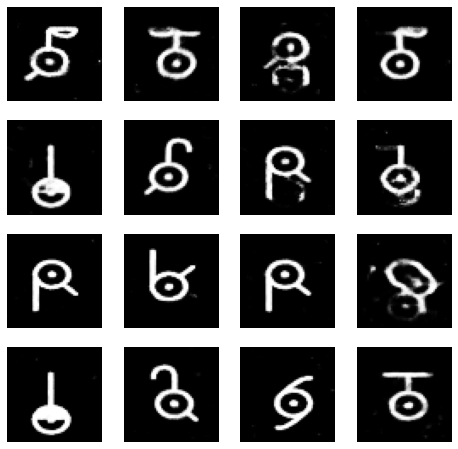

In [ ]:
train(x_train, EPOCHS)

In [ ]:
#generator2.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/generador3.h5")
#discriminator2.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/discriminator3.h5")
generator2.save("generador3.h5")
discriminator2.save("discriminator3.h5")

Finalmente, generamos unos datos aleatorios con 130 características y hacemos la predicción con el generador para ver las imágenes sintéticas que estamos generando. 

Observamos de nuevo lo comentado anteriormente. Generamos algunas imágenes que son practicamente iguales que las originales, y otras que sí que son nuevas y que mantienen la estructura general e innovan en algún aspecto. También hay alguna de las predicciones que no sale del todo bien. 

El hecho de que se repitan algunas de las imágenes se puede deber a que tan solo contábamos con 27 muestras iniciales. Por tanto, la variedad no es demasiada y puede deberse a eso que no haya tanta innovación.

In [ ]:
noise = tf.random.normal([100, 130])

pred=generator2(noise)

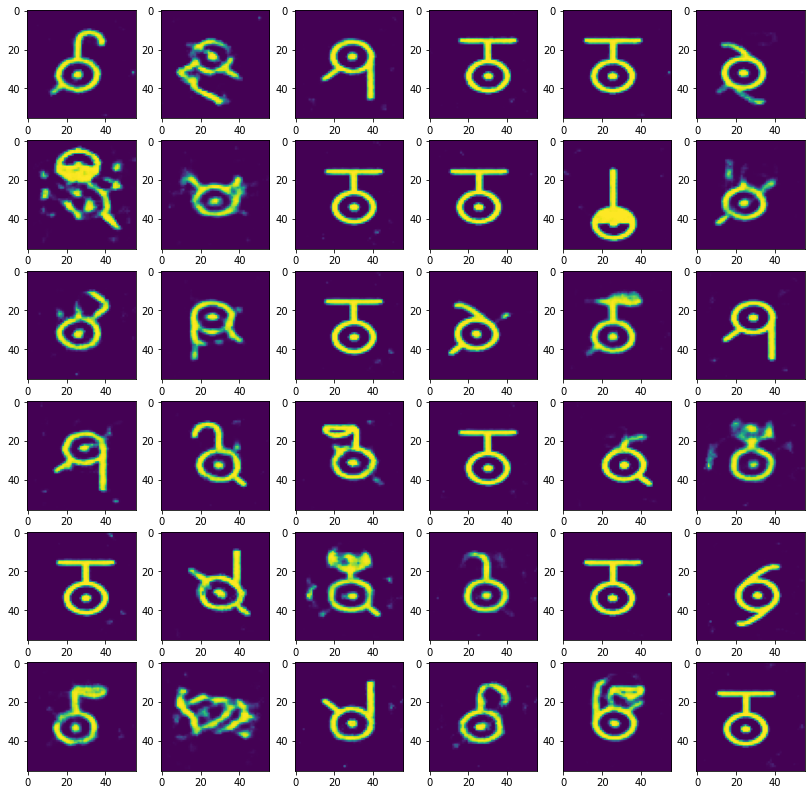

In [ ]:
plt.figure(figsize=(14,14))
pred=np.array(pred)
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.imshow(pred[i,:,:,0])

In [ ]:
#creación final del gift etc

anim_file = 'dcgan_unos_progresive_lowres2.mp4'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 10*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

#descargar
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Análisis de resultados y conclusiones 

Al generar unos cuantos elementos con el generador, podemos ver muchos pokemons de los que ya pertenecían al conjunto de entrenamiento, y otros que o bien son mezclas o deformaciones de estos. Para justificar esto, creemos que el escaso set de entrenamiento, y la limitada variedad de las formas, han limitado el "ingenio" del generador a adecuarse a las geometrías del set de imágenes reales. 

Nuestro objetivo en este trabajo realmente era implementar una GAN que generara pokemons desde ruido, e implementarla usando un crecimiento progresivo de la arquitectura de esta (https://arxiv.org/abs/1710.10196). Al implementar este crecimiento progresivo, (tras pruebas y errores, que por claridad del notebook no incluimos) hemos podido confirmar mejoras como:   

* Reducción en la cantidad de épocas necesarias para entrenar la red completa. Pues al partir de capas preentrenadas, los resultados de más alta resolución no necesitan empezar desde cero, tienen un punto de partida y eso acelera el proceso.  
* Aumento de la convergencia y la resolución posible. Una alta resolución no sería alcanzable si no fuera por métodos de entrenamiento progresivo, la red simplemente no sabría por donde empezar de la enorme cantidad de caminos disponibles. En nuestro caso, una imagen 56x56 no era posible con nuestros recursos (hardware), en un solo entrenamiendo, pero al segmentarlo en dos etapas, sí se logró la convergencia.  


Posibles mejoras:  
Tal como hemos mencionado, la "inventiva" del generador deja un poco que desear, posiblemente debido a la poca variedad en el conjunto de entrenamiento, lo cual genera un discriminador muy restrictivo frente a los patrones ligeramente nuevos. Para solucionar este problema proponemos tres soluciones:  

* La más obvia sería, aumentar el conjunto de entrenamiendo con nuevas muestra de pokemons del mismo estilo. (lamentablemente no hay más)

* Rotar el conjunto de entrenamiento. Al rotar y no solo reflejar (en X y en Y), obtenemos un conjunto mucho más rico de formas y patrones, que harían que el discriminador deba fijarse en características más "fundamentales" de las formas.  

* Limitar el discriminador y hacerlo más "tonto". Creemos que quizá limitando un poco la capacidad de discriminar, generador terminaría generando algunas formas más imaginativas, que aun así respeten la forma general de los pokemons.  
